In [ ]:
# run properties
context_size=256
embedd_features=12
learning_rate=1e-5
# hidden_features_per_layer = 512 # This parameter is not used for the LORA_resnet topology
residual_layer_count = 3
lora_r = 48

In [ ]:
# here, 
# the idea is to use a wide context window -- e.g. 256 -- throughout all layers
# but then to use LoRa modifier layers only, and deep, as much as my training limit allows
# and then compare how much can be learned, and how quickly


In [ ]:
import jax, flax, numpy
import flax.linen as nn
import orbax
from notebookinit import *
import jax.numpy as jnp
from sklearn.model_selection import train_test_split
import optax
import tiktoken
import lib_kata
from tqdm.auto import tqdm

In [ ]:
text_encoded, text_encoder, text_decoder, vocabulary_size = lib_kata.load_dataset_and_tokenize()
vocabulary_size

vocabulary: 
 ,e,t,o,a,i,h,s,r,n,
,l,d,u,m,y,w,,,c,f,g,b,p,:,k,v,.,',;,?,!,-,j,q,x,z,3,&,$ 
 size: 39 chars
first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you


39

In [ ]:
import pickle
if 1==0:
    print(f'creating data cache')
    X_all,y_all = lib_kata.make_training_Xy(text_encoded, context_size=context_size)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.05, shuffle=False, random_state=42)
    X_train=jnp.array(X_train)
    y_train=jnp.array(y_train)
    with open('datacache.pickle','wb') as f:
        pickle.dump((X_train,X_test,y_train, y_test), f)
    print(X_train.shape, y_train.shape)
else:
    with open('datacache.pickle','rb') as f:
        X_train,X_test,y_train, y_test = pickle.load(f)
    

In [ ]:
# lib_kata.preview_Xy(X=X_train, y=y_train, text_decoder=text_decoder, count=5, offset=0)

In [ ]:
X_small,y_small = lib_kata.make_training_Xy(text_encoded[0:2000], context_size=context_size)

example_X=X_small[0].reshape([1,context_size])

example_target_y=y_small[0].reshape([-1,1])
example_target_y_logits = nn.activation.one_hot(example_target_y,vocabulary_size)
# example_target_y_logits
# text_decoder(jnp.argmax(example_target_y_logits).reshape([-1,1]))

In [ ]:
class LSTMModel(nn.Module):
    context_size: int = 8
    embedd_features: int = 5
    LoRa_Rank: int = 8
    residual_layer_count: int = 7
    vocabulary_size: int = 39
    
    def setup(self):
        self.embedder = nn.Embed(num_embeddings=self.vocabulary_size, features=self.embedd_features)
        lstm_layer = nn.scan(nn.OptimizedLSTMCell,
                       variable_broadcast="params",
                       split_rngs={"params": False},
                       in_axes=1, 
                       out_axes=1,
                       length=max_len,
                       reverse=False)

        self.dense1 = nn.Dense(features=3)

    @nn.remat
    def __call__(self, x):
        h = self.embedder(x)
        h = h.reshape([-1,x.shape[-1]*self.embedd_features])
        h = self.dense1(h)
        y = h
        return y

example_thought_width=4
q_input1 = jnp.ones(shape=(1,example_thought_width), dtype=jnp.int32)
q = LSTMModel(context_size=5, embedd_features=7, LoRa_Rank=11, residual_layer_count=3, vocabulary_size=vocabulary_size)
q_param = q.init(jax.random.PRNGKey(0), example_X)
tabulate_fn = nn.tabulate(q, jax.random.PRNGKey(0), console_kwargs={'width':120, 'force_jupyter':True})
print(tabulate_fn(example_X))
y=q.apply(q_param, example_X)

                                   LSTMModel Summary                                    
┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module    ┃ inputs          ┃ outputs          ┃ params                   ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          │ LSTMModel │ int32[]         │ int32[]          │                          │
├──────────┼───────────┼─────────────────┼──────────────────┼──────────────────────────┤
│ embedder │ Embed     │ int32[1,256]    │ float32[1,256,7] │ embedding: float32[39,7] │
│          │           │                 │                  │                          │
│          │           │                 │                  │ 273 (1.1 KB)             │
├──────────┼───────────┼─────────────────┼──────────────────┼──────────────────────────┤
│ dense1   │ Dense     │ float32[1,1792] │ float32[1,3]     │ bias: float32[3]         │
│          │           │                 │                  │ kernel: float32[1792,3]  │
│          │           │                 │                  │                          │
│          │           │                 │                  │ 5,379 (21.5 KB)          │
├──────────┼───────────┼─────────────────┼──────────────────┼──────────────────────────┤
│          │           │                 │            Total │ 5,652 (22.6 KB)          │
└──────────┴───────────┴─────────────────┴──────────────────┴──────────────────────────┘
                                                                                        
                           Total Parameters: 5,652 (22.6 KB)                            

In [ ]:
y

Array([[-0.2354132 , -0.11094871,  0.31218055]], dtype=float32)

In [ ]:
class ResLayer(nn.Module):
    hidden_size: int = 16

    @nn.compact
    def __call__(self, x):
        h = nn.Dense(features=self.hidden_size)(x)
        h = nn.leaky_relu(h)
        y = x+h
        return y


class LoRaRes(nn.Module):
    LoRa_rank: int = 8

    @nn.compact
    def __call__(self,x):        
        inner = nn.Dense(name='compacter', features=self.LoRa_rank)(x)        
        inner_relu = nn.activation.leaky_relu(inner)
        outer = nn.DenseGeneral(name='expander', features=x.shape[-1], use_bias=False)(inner_relu)        
        y=x+outer
        y_normalized = nn.LayerNorm()(y)
        return y_normalized

example_thought_width = 32
q_input1 = jnp.ones(shape=(1,example_thought_width))
q_input2 = jnp.zeros(shape=(1,example_thought_width))
q = LoRaRes(LoRa_rank = 8)
q_param = q.init(jax.random.PRNGKey(0), q_input1)
tabulate_fn = nn.tabulate(q, jax.random.PRNGKey(0), console_kwargs={'width':120, 'force_jupyter':True})
print(tabulate_fn(q_input1))      

                                   LoRaRes Summary                                    
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module       ┃ inputs        ┃ outputs       ┃ params                ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│             │ LoRaRes      │ float32[1,32] │ float32[1,32] │                       │
├─────────────┼──────────────┼───────────────┼───────────────┼───────────────────────┤
│ compacter   │ Dense        │ float32[1,32] │ float32[1,8]  │ bias: float32[8]      │
│             │              │               │               │ kernel: float32[32,8] │
│             │              │               │               │                       │
│             │              │               │               │ 264 (1.1 KB)          │
├─────────────┼──────────────┼───────────────┼───────────────┼───────────────────────┤
│ expander    │ DenseGeneral │ float32[1,8]  │ float32[1,32] │ kernel: float32[8,32] │
│             │              │               │               │                       │
│             │              │               │               │ 256 (1.0 KB)          │
├─────────────┼──────────────┼───────────────┼───────────────┼───────────────────────┤
│ LayerNorm_0 │ LayerNorm    │ float32[1,32] │ float32[1,32] │ bias: float32[32]     │
│             │              │               │               │ scale: float32[32]    │
│             │              │               │               │                       │
│             │              │               │               │ 64 (256 B)            │
├─────────────┼──────────────┼───────────────┼───────────────┼───────────────────────┤
│             │              │               │         Total │ 584 (2.3 KB)          │
└─────────────┴──────────────┴───────────────┴───────────────┴───────────────────────┘
                                                                                      
                            Total Parameters: 584 (2.3 KB)                            

In [ ]:
z = q.apply(q_param,q_input1)
z

Array([[ 0.35061917,  0.3156343 , -0.79411525,  0.10029031, -1.7164958 ,
         0.14255805,  1.5007938 ,  0.23301879,  1.0444974 ,  0.30757236,
         0.8750215 , -0.02512331, -1.3448353 , -0.07219965,  1.2827805 ,
        -2.2191029 ,  0.96754193, -0.5667253 , -0.010443  , -1.9919719 ,
         0.9765774 ,  0.38084677, -0.36160332,  1.7763048 ,  0.5061463 ,
        -0.24435517, -1.4704536 , -0.05857546,  1.5704482 , -0.09050263,
        -0.5575002 , -0.80665183]], dtype=float32)

In [ ]:
  
class SimpleNN3(nn.Module):
    # batch size is implied from data
    
    context_size: int = 8
    embedd_features: int = 5
    LoRa_Rank: int = 8
    residual_layer_count: int = 7
    vocabulary_size: int = 39
    # Note: at first, the "thought width" is equal to context size times the embedding dimension
    

    def setup(self):
        # print(self.context_size, self.embedd_features, "->", self.context_size * self.embedd_features,)
        pass

    @nn.compact
    def __call__(self,x):
        # first, embedd the input
        y0 = nn.Embed(name='embedding',num_embeddings=self.vocabulary_size, features=self.embedd_features)(x)
        # flatten the input vector, as there is no conceptual difference between the token's identity and token's feature here:        
        h = y0.reshape([-1,self.context_size*self.embedd_features])
        
        # proced with the signal processor layers
        for idx_layer in range(residual_layer_count):
            h = LoRaRes(LoRa_rank = self.LoRa_Rank)(h)
        
        # final dense layer down to prediction logits. Note that there might be more logits than in the hidden state, that's OK.
        h = nn.Dense(name='layer_final',features=self.vocabulary_size)(h)  
        y = h
        return y
        
        


# simpleNN3 = SimpleNN3(context_size=context_size, embedd_features=embedd_features, residual_layer_count = 7, LoRa_Rank = lora_r)
# simpleNN3_params = simpleNN3.init(jax.random.PRNGKey(0), example_X)

# tabulate_fn = nn.tabulate(simpleNN3, jax.random.PRNGKey(0), console_kwargs={'width':120, 'force_jupyter':True})
# print(tabulate_fn(example_X))
# print(f'{simpleNN3.apply(simpleNN3_params,example_X).shape=}')
# predicted_logits = simpleNN3.apply(simpleNN3_params,example_X)
# predicted_example_token = jnp.argmax(simpleNN3.apply(simpleNN3_params,example_X), axis=1)
# predicted_logits_str = ", ".join([f'{float(predicted_logits[1,x]):0.2f}' for x in range(predicted_logits.shape[1])])
# print(predicted_logits_str)
# print(f'predicted token: ', predicted_example_token, "-> >>>", text_decoder(predicted_example_token),"<<<")
# print(f'   target token: ', example_target_y, f"confidence: {float(predicted_logits[0,predicted_example_token][0]):0.3f}")


In [ ]:
example_target_y

array([[16]], dtype=int32)

In [ ]:
# def cross_entropy_loss(logits, labels):
#     """Returns cross-entropy loss."""
#     assert jnp.all(logits.shape==labels.shape)
#     return -jnp.mean(jnp.sum(logits * labels, axis=1))

In [ ]:
# predicted_logits

In [ ]:
# predicted_logits.shape

In [ ]:
example_target_y.shape

(1, 1)

In [ ]:
# demo the library softmax error checker
# optax.softmax_cross_entropy_with_integer_labels(predicted_logits, example_target_y[0])

In [ ]:
# example loss between the target and predicted
# jnp.log10(optax.softmax_cross_entropy_with_integer_labels(predicted_logits, example_target_y[0]))

In [ ]:
# I think I am ready to do a training step

In [ ]:
train_minibatch_size = 2*4096
examples_per_epoch = len(X_train) - train_minibatch_size  # how many unique examples of input-output pairs can we produce out of the train-time dataset
batches_per_epoch =  len(X_train) // train_minibatch_size
print(f'batches_per_epoch per epoch: {batches_per_epoch} with minibatch size of {train_minibatch_size}')
starter_X_minibatch = jnp.array(X_train[0:train_minibatch_size])
starter_y_minibatch = jnp.array(X_train[0:train_minibatch_size])


simpleNN3_minibatched = SimpleNN3(context_size=context_size, embedd_features=embedd_features, residual_layer_count = 7, LoRa_Rank = lora_r)
simpleNN3_minibatched_params = simpleNN3_minibatched.init(jax.random.PRNGKey(0), starter_X_minibatch)

tabulate_fn = nn.tabulate(simpleNN3_minibatched, jax.random.PRNGKey(0), console_kwargs={'width':120, 'force_jupyter':True})
print(tabulate_fn(starter_X_minibatch))

batches_per_epoch per epoch: 129 with minibatch size of 8192


                                               SimpleNN3 Summary                                                
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module       ┃ inputs             ┃ outputs              ┃ params                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ SimpleNN3    │ int32[8192,256]    │ float32[8192,39]     │                           │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ embedding             │ Embed        │ int32[8192,256]    │ float32[8192,256,12] │ embedding: float32[39,12] │
│                       │              │                    │                      │                           │
│                       │              │                    │                      │ 468 (1.9 KB)              │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_0             │ LoRaRes      │ float32[8192,3072] │ float32[8192,3072]   │                           │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_0/compacter   │ Dense        │ float32[8192,3072] │ float32[8192,48]     │ bias: float32[48]         │
│                       │              │                    │                      │ kernel: float32[3072,48]  │
│                       │              │                    │                      │                           │
│                       │              │                    │                      │ 147,504 (590.0 KB)        │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_0/expander    │ DenseGeneral │ float32[8192,48]   │ float32[8192,3072]   │ kernel: float32[48,3072]  │
│                       │              │                    │                      │                           │
│                       │              │                    │                      │ 147,456 (589.8 KB)        │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_0/LayerNorm_0 │ LayerNorm    │ float32[8192,3072] │ float32[8192,3072]   │ bias: float32[3072]       │
│                       │              │                    │                      │ scale: float32[3072]      │
│                       │              │                    │                      │                           │
│                       │              │                    │                      │ 6,144 (24.6 KB)           │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_1             │ LoRaRes      │ float32[8192,3072] │ float32[8192,3072]   │                           │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_1/compacter   │ Dense        │ float32[8192,3072] │ float32[8192,48]     │ bias: float32[48]         │
│                       │              │                    │                      │ kernel: float32[3072,48]  │
│                       │              │                    │                      │                           │
│                       │              │                    │                      │ 147,504 (590.0 KB)        │
├───────────────────────┼──────────────┼────────────────────┼──────────────────────┼───────────────────────────┤
│ LoRaRes_1/expander    │ DenseGeneral │ float32[8192,48]   │ float32[8192,3072]   │ kernel: float32[48,3072]  │
│                       │              │                    │                      │                           │
│                       │              │     

In [ ]:
model_param_count = numpy.sum(numpy.array([numpy.prod(x.shape) for x in jax.tree_util.tree_leaves(simpleNN3_minibatched_params)]))
model_size_str = f'LR_{model_param_count/1e3:0.1f}k_D{residual_layer_count}'
print(f'model size: {model_size_str}')
train_data_size = len(X_train)
print(f'model size to dataset size ratio: {model_param_count/train_data_size:0.3f}')

model size: LR_2228.0k_D7
model size to dataset size ratio: 2.103


(1059381,)

(1059381, 256)

In [ ]:
def prep_minibatch(minibatch_idx=0):
    minibatch_ptr = minibatch_idx*train_minibatch_size
    X_minibatch = jnp.array(X_train[minibatch_ptr:minibatch_ptr+train_minibatch_size,:])
    y_minibatch = jnp.array(y_train[minibatch_ptr:minibatch_ptr+train_minibatch_size])
    y_minibatch_target_logits = nn.activation.one_hot(y_minibatch,vocabulary_size)    
    return X_minibatch, y_minibatch, y_minibatch_target_logits
minibatch_idx = 4
minibatch_X, minibatch_y, y_minibatch_target_logits =prep_minibatch(minibatch_idx=minibatch_idx)

In [ ]:
%timeit minibatch_X, minibatch_y, y_minibatch_target_logits =prep_minibatch(minibatch_idx=minibatch_idx)

509 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
print(y_minibatch_target_logits.devices())

{cuda(id=0)}


In [ ]:
model_starter_params = simpleNN3_minibatched_params
model_moving_params = model_starter_params.copy()
#optimizer = optax.adabelief(learning_rate=learning_rate)
optimizer = optax.adamw(learning_rate=learning_rate)
optimizer_state = optimizer.init(model_moving_params)
step_count=0
minibatch_idx = 0
examples_seen = 0

In [ ]:
import wandb

In [ ]:
wandb.finish()

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="04_lora_resnet",    
    name=model_size_str,
    # track hyperparameters and run metadata
    config={
        'model_param_count':model_param_count,
        "examples_per_epoch":examples_per_epoch,
        "batches_per_epoch":batches_per_epoch,
        "context_size":context_size,
        "embedd_features":embedd_features,
        "learning_rate": learning_rate,
        "layer_count": residual_layer_count,
        "lora_r" : lora_r,
        "type" : "lora_resnet"
    }
    )

wandb: Currently logged in as: greygoo. Use `wandb login --relogin` to force relogin


In [ ]:
# attempt validation accuracy
@jax.jit
def validate(model_params, validation_size=8*4096):
    validation_expected_tokens = jnp.array(y_test[0:validation_size])
    validation_predicted_logits = simpleNN3_minibatched.apply(model_params, jnp.array(X_test[0:validation_size]))
    validation_loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(validation_predicted_logits, validation_expected_tokens))
    predicted_tokens = jnp.argmax(validation_predicted_logits, axis=1)
    accurate_tokens = jnp.sum(predicted_tokens==validation_expected_tokens)
    accuracy_ratio = accurate_tokens/validation_size
    return validation_loss, accuracy_ratio

q=validate(model_starter_params)
q

(Array(4.2064886, dtype=float32), Array(0.01635742, dtype=float32))

In [ ]:
loss_fn = lambda model_params, X,y : jnp.mean(optax.softmax_cross_entropy_with_integer_labels(simpleNN3_minibatched.apply(model_params,X),  y))
jitted_val_and_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))

In [ ]:
q[0].devices()

{cuda(id=0)}

In [ ]:
%timeit validate(model_starter_params)

83.1 ms ± 291 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit loss_value, gradients = jitted_val_and_grad(model_moving_params, minibatch_X, minibatch_y)  

193 µs ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit minibatch_X, minibatch_y, y_minibatch_target_logits =prep_minibatch(minibatch_idx=minibatch_idx)

505 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
minibatch_X.devices()

{cuda(id=0)}

In [ ]:
# training loop:
# epochs, and inside, batches

for idx_epoch in tqdm(range(1000), desc="epoch"):
    for idx_minibatch in tqdm(range(batches_per_epoch), leave=False,  desc="batch in epoch" ):
        step_count+=1
        minibatch_idx = step_count % batches_per_epoch        
        minibatch_X, minibatch_y, y_minibatch_target_logits =prep_minibatch(minibatch_idx=minibatch_idx)        
        loss_value, gradients = jitted_val_and_grad(model_moving_params, minibatch_X, minibatch_y)        
        model_param_updates, optimizer_state = optimizer.update(gradients, optimizer_state, params=model_moving_params)
        model_moving_params = optax.apply_updates(model_moving_params, model_param_updates)
        examples_seen += train_minibatch_size
        
        validation_loss, validation_accuracy_ratio = validate(model_moving_params)
        wandb.log({
            "step_count":step_count, 
            "dataset_seen_ratio":examples_seen/examples_per_epoch, 
            "train_loss_value": loss_value,            
            "validation_loss":validation_loss, 
            "validation_accuracy_ratio":validation_accuracy_ratio,
            })
        

# After training, generate example text with a prompt from the validation data.

starter_prompt = jnp.array(X_train[0])

def predict_text(model_params, prompt_encoded, new_characters=250):
    prediction_decoded = text_decoder(prompt_encoded)
    print(f'{prediction_decoded}')
    print(f'-------------------------------------------------------')
    running_prompt = prompt_encoded.copy()
    continuation = ""
    # print(running_prompt)
    for char_idx in range(new_characters):
        predicted_logits = simpleNN3_minibatched.apply(model_params, running_prompt)
        predicted_token = jnp.argmax(predicted_logits).reshape((1,1))
        predicted_char = text_decoder(predicted_token)
        continuation = f'{continuation}{predicted_char}'
        running_prompt = jnp.hstack([running_prompt[1:],predicted_token[:,0]])
        # print(running_prompt)
    return continuation  
example_generation = predict_text(model_moving_params, starter_prompt)
print(example_generation)
wandb.log({'example_generation_html':wandb.Html(example_generation)})
wandb.finish()


epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

batch in epoch:   0%|          | 0/129 [00:00<?, ?it/s]

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:

-------------------------------------------------------
and the shal the shall the stander the well
the shall the shall the shall the stranges and the strangelo the shall the so me strius a shall the shall the shall the shall the strangelo to shall the shall the strance the shout in the strance vill the s


dataset_seen_ratio,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
step_count,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_value,█▅▄▃▃▃▃▂▂▂▃▂▂▂▁▂▁▂▁▁▂▂▁▁▁▂▁▂▂▁▁▁▂▂▁▁▁▂▁▁
validation_accuracy_ratio,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇██▇██████████████████████
validation_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dataset_seen_ratio,1005.30732
step_count,129000
train_loss_value,1.64319
validation_accuracy_ratio,0.46317
validation_loss,1.78796


In [ ]:
raise

RuntimeError: No active exception to reraise

In [ ]:
!git add .
!git commit -m 'savegame. now appears to train.'
!git push

In [ ]:
from notebookinit import *
save_notebook()

In [ ]:
starter_prompt = jnp.array(X_train[0])
#starter_prompt = jnp.array(X_test[0])
random_key = jax.random.PRNGKey(42)
temperature = 5.0
def predict_text(model_params, prompt_encoded, new_characters=1500):
    prediction_decoded = text_decoder(prompt_encoded)
    print(f'{prediction_decoded}')
    print(f'-------------------------------------------------------')
    running_prompt = prompt_encoded.copy()
    continuation = ""
    # print(running_prompt)
    for char_idx in range(new_characters):
        predicted_logits = nn.softmax(simpleNN3_minibatched.apply(model_params, running_prompt) *(1.0/temperature))
        extra_noise = jax.random.uniform(random_key, shape=predicted_logits.shape)      
        predicted_token = jnp.argmax(predicted_logits).reshape((1,1))
        predicted_char = text_decoder(predicted_token)
        print(f'{predicted_char}',end='')
        continuation = f'{continuation}{predicted_char}'
        running_prompt = jnp.hstack([running_prompt[1:],predicted_token[:,0]])
        # print(running_prompt)
    return continuation  
example_generation = predict_text(model_moving_params, starter_prompt)
# print(example_generation)

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you know caius marcius is chief enemy to the people.

all:

-------------------------------------------------------
and the shal the shall the stander the well
the shall the shall the shall the stranges and the strangelo the shall the so me strius a shall the shall the shall the shall the strangelo to shall the shall the strance the shout in the strance vill the strant the strain the shall the stres and the shall the shal shall the strain the shall the shall the shall the shall the shall the stand the shall the shall the strance the shall the shall the strance the shall the shall the shall the strance the shall the shall the strangelo the strain the shall the shall the shall the shall the strant the shall the strance the strangelo the some the shall the stand the shall the strius and the shal

(array([8., 9., 6., 2., 7., 1., 3., 1., 1., 1.]),
 array([0.00039873, 0.00859406, 0.01678938, 0.02498471, 0.03318004,
        0.04137536, 0.04957068, 0.05776601, 0.06596133, 0.07415666,
        0.08235198]),
 <BarContainer object of 10 artists>)

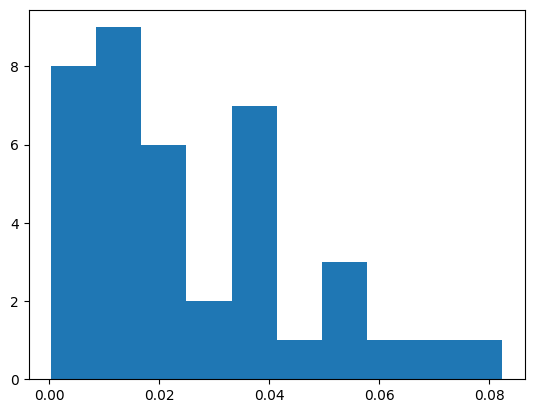

In [ ]:
predicted_logits = nn.softmax(simpleNN3_minibatched.apply(model_moving_params, starter_prompt)/4.0)
plt.hist(predicted_logits)

In [ ]:
predicted_logits


NameError: name 'predicted_logits' is not defined

In [ ]:
jax